In [1]:
from xmitgcm import open_mdsdataset
import xgcm
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import math
import xarray as xr
import string
import dask.array as da
import vertmodes

import warnings

warnings.filterwarnings('ignore')

In [2]:
currentDirectory = os.getcwd()
data_dir = currentDirectory[:-7] + '/input/'
print(data_dir)

/project/6001902/jxchang/HighRes1/results/TideU008N0LinH200ho1402DAh0200Cdqdt003/input/


In [3]:
ds1 = open_mdsdataset(data_dir, geometry='cartesian',endian='<',prefix=['statevars'])

grid = xgcm.Grid(ds1, periodic=False)
print(grid)

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
T Axis (not periodic, boundary=None):
  * center   time
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center


In [4]:
t = 0
f0 = 1.e-4
g = 9.8
rhoNil=999.8

om=2*np.pi/12.4/3600
alpha = 2e-4
beta = 0.
nz = 200
#dz=H/nz 
tR_fname="../indata/TRef.bin"
tRef = np.fromfile(tR_fname)
refSalt=35.
refTemp=tRef[0]

rho2=rhoNil*(1-(alpha*(tRef-refTemp)))
print(rho2)
rhoS=np.roll(rho2,1)
N2=g/rhoNil*(rho2-rhoS)/ds1['drF'].values
N2[0]=g/rhoNil*(rhoS[0]-rho2[0])/ds1['drF'][0]
print(N2)

[ 999.8        1004.37837649 1005.82267008 1006.20775394 1006.66329472
 1006.78566995 1006.8696037  1006.98624331 1007.10039947 1007.2146081
 1007.33636299 1007.37812997 1007.45710888 1007.55324449 1007.63389572
 1007.66446782 1007.67364771 1007.68836113 1007.69695044 1007.711887
 1007.71895969 1007.72654518 1007.73005209 1007.73237933 1007.73318594
 1007.73475566 1007.74268512 1007.74389656 1007.74442976 1007.74529036
 1007.74697721 1007.74815143 1007.75143179 1007.75471215 1007.75799251
 1007.76127287 1007.76455322 1007.76783358 1007.77111394 1007.7743943 ]
[1.56329394e-02 8.97541301e-03 2.83138170e-03 7.54915362e-04
 8.93038521e-04 2.39903442e-04 1.64543064e-04 2.28659362e-04
 2.23790836e-04 2.23893694e-04 2.38687317e-04 8.18796462e-05
 1.54829634e-04 1.88463486e-04 1.58108042e-04 5.99332922e-05
 1.79961949e-05 2.88440633e-05 1.68384156e-05 2.92815186e-05
 1.38652440e-05 1.48705259e-05 6.87492790e-06 4.56230464e-06
 1.58126215e-06 3.07728106e-06 1.55448494e-05 2.37489787e-06
 1.0452

In [5]:
xmin = 13000
xmax = 67000
ymin = 0
ymax = 3000
                                        
ttlen=len(ds1.time)
TC=np.int(np.floor(ttlen/24))
print('the length of time:' + str(ttlen) )
print('initial temp: '+ str(tRef))
print('number of tidal cycle:'+ str(TC))

the length of time:173
initial temp: [63.59230582 40.69584406 33.47293155 31.54712706 29.26896757 28.65696899
 28.23721628 27.65390158 27.08300659 26.5118492  25.90295299 25.69407634
 25.29910279 24.81832859 24.41499174 24.26210069 24.21619203 24.14261024
 24.0996551  24.02495734 23.98958682 23.95165181 23.93411373 23.9224752
 23.91844136 23.91059116 23.87093593 23.86487752 23.86221099 23.85790713
 23.84947122 23.84359894 23.82719386 23.81078878 23.79438371 23.77797863
 23.76157355 23.74516847 23.72876339 23.71235831]
number of tidal cycle:7


In [6]:
time=ds1.coords['time'].values/np.timedelta64(1, 's')
#time=ds2.coords['time'].values/np.timedelta64(1, 's')
xc=ds1.coords['XC']
xg=ds1.coords['XG']
yc=ds1.coords['YC']
yg=ds1.coords['YG']
z=ds1.coords['Z']
dz=-np.median(np.diff(z))
ds1["N2"]=xr.DataArray(N2,coords=[z],dims=["Z"])
ds1['tRef']=xr.DataArray(tRef,coords=[z],dims=['Z'])

In [7]:
psi,phi,ce,zph = vertmodes.vertModes(N2,dz)
print(np.shape(psi))
for i in range(4):
    print('int psi 0 psi %d:  %1.2e'%(i,np.sum(psi[:,0]*psi[:,i]*dz)))

(40, 37)
int psi 0 psi 0:  1.00e+00
int psi 0 psi 1:  2.54e-12
int psi 0 psi 2:  9.72e-14
int psi 0 psi 3:  -4.49e-13


In [8]:
#adjust the normalization of vertical mode to H
Nm=37
H=ds1.drF.sum("Z").values
for i in range(Nm):
    exec('psi%s=psi[:,i]*H**0.5'%i)
    exec('phi%s=phi[:,i]*H**0.5'%i)
    exec('ds1["psi%s"]=xr.DataArray(psi%s,coords=[z],dims=["Z"])'%(i,i))
    exec('ds1["phi%s"]=xr.DataArray(phi%s,coords=[z],dims=["Z"])'%(i,i))

print('int psi 0 psi 0:  '+str(np.sum(psi0*psi0*dz)))

int psi 0 psi 0:  200.00000000000006


In [9]:
t_st=120
VW=grid.interp(ds1['VVEL'],axis=('X','Y'),boundary='extrapolate')
for tt in range(t_st,t_st+1):
    print(tt)
    U0=(ds1['UVEL'].isel(time=tt)*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).sum('Z')
    VW0=(VW.isel(time=tt)*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).sum('Z')
    VS0=(ds1['VVEL'].isel(time=tt)*ds1['drF']*ds1['hFacS']*ds1['maskS']).sum('Z')/(ds1.drF*ds1.hFacS*ds1.maskS).sum('Z')
    PW=grid.interp(ds1['PHIHYD'].isel(time=tt),axis='X',boundary='extrapolate')
    PS=grid.interp(ds1['PHIHYD'].isel(time=tt),axis='Y',boundary='extrapolate')
    #print(PW[2,60:63,723:726].values)
    #print(PS[2,60:63,723:726].values)
    PW0=(PW*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).sum('Z')
    PS0=(PS*ds1['drF']*ds1['hFacS']*ds1['maskS']).sum('Z')/(ds1.drF*ds1.hFacS*ds1.maskS).sum('Z')
    #print(PW0[60:63,723:726].values)

    up=(ds1.UVEL.isel(time=tt)-U0).where(ds1.maskW!=0,np.nan)
    print('processed up')
    vwp=(VW.isel(time=tt)-VW0).where(ds1.maskW!=0,np.nan)
    vsp=(ds1.VVEL.isel(time=tt)-VS0).where(ds1.maskS!=0,np.nan)
    print('vp')
    ppw=(PW-PW0).where(ds1.maskW!=0,np.nan)
    print('ppw')
    pps=(PS-PS0).where(ds1.maskS!=0,np.nan)
    print('pps')
    del U0,VS0,VW0,PW0,PS0


    for i in range(Nm):
        exec('u%s=(up*ds1.psi%s*ds1.drF).sum("Z")/H'% (i,i))
        #exec('print(u%s[60,720].values)'%i)
        exec('pw%s=(ppw*ds1.psi%s*ds1.drF).sum("Z")/H'%(i,i))
        exec('vs%s=(vsp*ds1.psi%s*ds1.drF).sum("Z")/H'%(i,i))
        exec('vw%s=(vwp*ds1.psi%s*ds1.drF).sum("Z")/H'%(i,i))
        exec('ps%s=(pps*ds1.psi%s*ds1.drF).sum("Z")/H'%(i,i))
        exec('fx%s=u%s*pw%s*H'%(i,i,i)) 
        #exec('fx2_%s=(u%s*pw%s*ds1.psi%s*ds1.psi%s*ds1.drF).sum("Z")'%(i,i,i,i,i))
        exec('fy%s=vs%s*ps%s'%(i,i,i))
        #exec('EK1_%s=0.5*((u%s*u%s*ds1.psi%s*ds1.psi%s+vw%s*vw%s*ds1.psi%s*ds1.psi%s)*ds1.drF).sum("Z")'% (i,i,i,i,i,i,i,i,i))
        exec('EK%s=0.5*(u%s*u%s+vw%s*vw%s)*H'% (i,i,i,i,i))
        #exec('EK2_%s=0.5*((u%s*u%s+vw%s*vw%s)*ds1.drF).sum("Z")'% (i,i,i,i,i))
        exec('EP%s=0.5*(pw%s*pw%s/ce[i]/ce[i])*H'% (i,i,i))
        #exec('EP2_%s=0.5*((pw%s*pw%s/ce[i]/ce[i])*ds1.drF).sum("Z")'% (i,i,i))
        exec('E%s=EK%s+EP%s'%(i,i,i))
        #exec('print(fx%s[60,720].values)'%i)
        #exec('Fx%s_t[tt-t_st,:,:]=fx%s'%(i,i))
        #exec('Fy%s_t[tt-t_st,:,:]=fy%s'%(i,i))
        exec('cE%s=xr.concat([-ce[i]*E%s[:, :720], ce[i]*E%s[:, 720:]], dim="XG")'%(i,i,i))
        exec('del u%s,pw%s,vs%s,vw%s,ps%s'%(i,i,i,i,i))
        #exec('print("mode%s")'%i)
BCrad=0
del vsp,pps

120
processed up
vp
ppw
pps


In [10]:
total_fx_n = np.zeros((len(yc),len(xg)))
total_EK_n = np.zeros((len(yc),len(xg)))
total_EP_n = np.zeros((len(yc),len(xg)))
total_cE_n = np.zeros((len(yc),len(xg)))

for i in range(Nm):
    exec('total_fx_n += fx%s.values' %i)
    exec('total_EK_n += EK%s.values' %i)
    exec('total_EP_n += EP%s.values' %i)
    exec('total_cE_n += cE%s.values' %i)

In [11]:
ds2 = open_mdsdataset(data_dir, geometry='cartesian',endian='<',prefix=['energymvars'])
uPbc=xr.DataArray(ds2['SDIAG6'].data, coords=[ds2.time,yc,xg], dims=['time','YC','XG'])
print(uPbc)

<xarray.DataArray 'concatenate-21b380b8588297c5d7c481b79219fe84' (time: 172, YC: 120, XG: 1440)>
dask.array<concatenate, shape=(172, 120, 1440), dtype=float64, chunksize=(1, 120, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) timedelta64[ns] 00:31:00 01:02:00 ... 3 days 16:52:00
  * YC       (YC) float64 12.5 37.5 62.5 87.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG       (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04


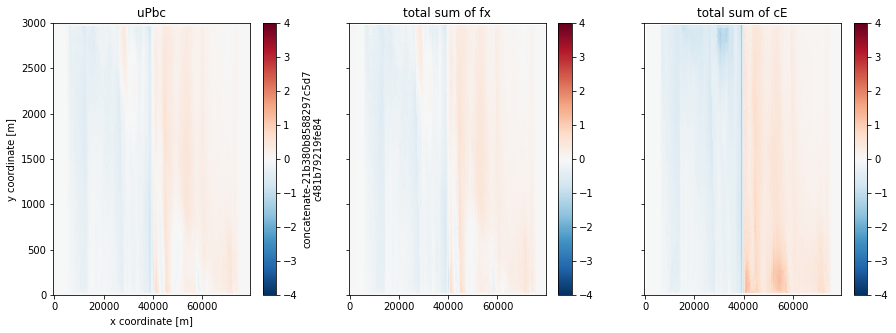

In [12]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

uPbc.isel(time=t_st).plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-4,vmax=4)
ax[0].set_title("uPbc")

pm=ax[1].pcolormesh(xc,yg,total_fx_n[:-1,:-1],cmap="RdBu_r",vmin=-4,vmax=4)
ax[1].set_title("total sum of fx")
f.colorbar(pm, ax=ax[1])

pm=ax[2].pcolormesh(xc,yg,total_cE_n[:-1,:-1],cmap="RdBu_r",vmin=-4,vmax=4)
ax[2].set_title("total sum of cE")
f.colorbar(pm, ax=ax[2])

In [13]:
EK = 0.5*(ds1.UVEL*ds1.UVEL+VW*VW)
EKp = 0.5*(up*up+vwp*vwp)

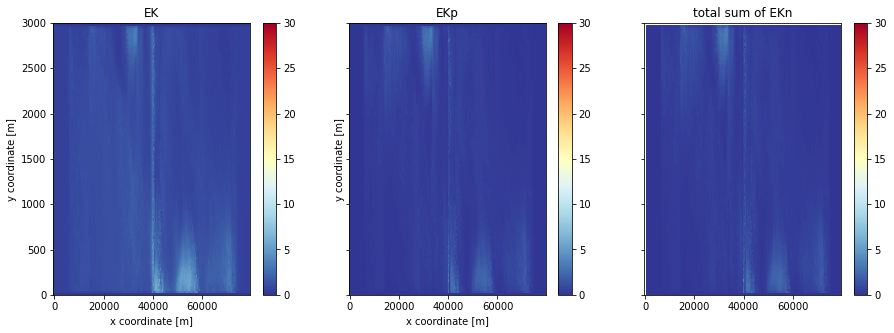

In [14]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

(EK*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(time=t_st).plot(ax=ax[0],y="YC",cmap="RdYlBu_r",vmax=30)
ax[0].set_title("EK")

(EKp*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').plot(ax=ax[1],y="YC",cmap="RdYlBu_r",vmax=30)
ax[1].set_title("EKp")

pm=ax[2].pcolormesh(xc,yg,total_EK_n[:-1,:-1],cmap="RdYlBu_r",vmax=30)
ax[2].set_title("total sum of EKn")
f.colorbar(pm, ax=ax[2])

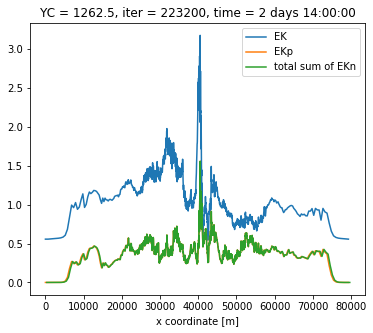

In [15]:
f, ax =plt.subplots(1,1,figsize=(6,5))

(EK*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(time=t_st,YC=50).plot(ax=ax,label="EK")
(EKp*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(YC=50).plot(ax=ax,label="EKp")

ax.plot(xc,total_EK_n[50,:],label="total sum of EKn")
ax.legend()

In [16]:
rho=rhoNil*(1-(alpha*(ds1.THETA-refTemp)))

In [17]:
print(rho.isel(time=120,YC=50,XC=400).values)

[1003.50925444 1003.82175799 1004.30657217 1005.30439594 1006.61309987
 1007.18243578 1007.33740431 1007.36253292 1007.39726052 1007.42691013
 1007.44763684 1007.45655559 1007.46359503 1007.49601687 1007.55300196
 1007.57786023 1007.61601233 1007.66517988 1007.71283185 1007.72939189
 1007.73078914 1007.73103635 1007.73138876 1007.73218479 1007.73366521
 1007.73595463 1007.73879593 1007.74173833 1007.74443762 1007.74671829
 1007.74888339 1007.75126241 1007.75385525 1007.75656977 1007.75935217
 1007.76220137 1007.76514993 1007.76821978 1007.77117781 1007.77281837]


In [18]:
rhob=rho2-rhoNil
ds1["rhob"]=xr.DataArray(rhob,coords=[z],dims=['Z'])

In [19]:
print(rhob)

[0.         4.57837649 6.02267008 6.40775394 6.86329472 6.98566995
 7.0696037  7.18624331 7.30039947 7.4146081  7.53636299 7.57812997
 7.65710888 7.75324449 7.83389572 7.86446782 7.87364771 7.88836113
 7.89695044 7.911887   7.91895969 7.92654518 7.93005209 7.93237933
 7.93318594 7.93475566 7.94268512 7.94389656 7.94442976 7.94529036
 7.94697721 7.94815143 7.95143179 7.95471215 7.95799251 7.96127287
 7.96455322 7.96783358 7.97111394 7.9743943 ]


In [20]:
rhow=rho-ds1.rhob-rhoNil
print(rhow.isel(time=120,YC=50,XC=400).values)

[ 3.70925444e+00 -5.56618506e-01 -1.51609791e+00 -9.03358001e-01
 -5.01948442e-02  3.96765824e-01  4.67800608e-01  3.76289611e-01
  2.96861049e-01  2.12302023e-01  1.11273851e-01  7.84256271e-02
  6.48615443e-03 -5.72276212e-02 -8.08937652e-02 -8.66075910e-02
 -5.76353855e-02 -2.31812487e-02  1.58814095e-02  1.75048846e-02
  1.18294519e-02  4.49116960e-03  1.33666576e-03 -1.94537236e-04
  4.79273505e-04  1.19896894e-03 -3.88919617e-03 -2.15823333e-03
  7.85426835e-06  1.42792797e-03  1.90618615e-03  3.11098502e-03
  2.42346160e-03  1.85762742e-03  1.35966256e-03  9.28501171e-04
  5.96704939e-04  3.86195169e-04  6.38665142e-05 -1.57593858e-03]


In [21]:
print(rhow.isel(time=120,YC=50,XC=700).values)

[ 3.65868982 -0.76424313 -1.65426761 -0.86571646 -0.01808558  0.50239809
  0.54205155  0.47146491  0.38465548  0.29874463  0.23436708  0.28036527
  0.25759473  0.17846525  0.1051337   0.07729442  0.0694896   0.05540678
  0.0469889   4.80403047  4.79695778  4.7893723   4.78586538  4.78353814
  4.78273154  4.78116181  4.77323235  4.77202091  4.77148771  4.77062711
  4.76894027  4.76776604  4.76448568  4.76120533  4.75792497  4.75464461
  4.75136425  4.74808389  4.74480353  4.74152317]


In [22]:
EP=g*g*rhow*rhow/(2*rhoNil*rhoNil*ds1.N2)

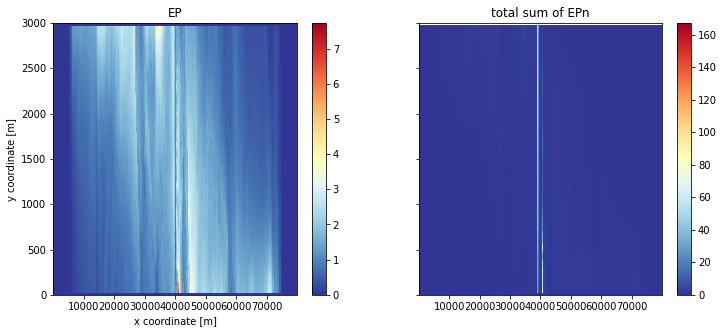

In [23]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

(EP*ds1['drF']*ds1['hFacC']*ds1['maskC']).sum('Z').isel(time=t_st).plot(ax=ax[0],y="YC",cmap="RdYlBu_r")
ax[0].set_title("EP")

pm=ax[1].pcolormesh(xc,yg,total_EP_n[:-1,:-1],cmap="RdYlBu_r")
ax[1].set_title("total sum of EPn")
f.colorbar(pm, ax=ax[1])

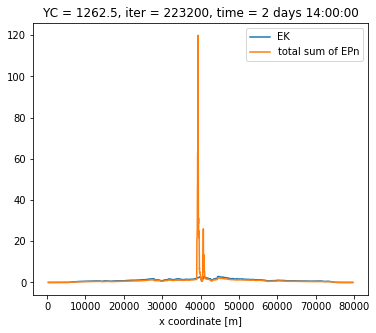

In [24]:
f, ax =plt.subplots(1,1,figsize=(6,5))

(EP*ds1['drF']*ds1['hFacC']*ds1['maskC']).sum('Z').isel(time=t_st,YC=50).plot(ax=ax,label="EK")

ax.plot(xc,total_EP_n[50,:],label="total sum of EPn")
ax.legend()

(20000.0, 60000.0)

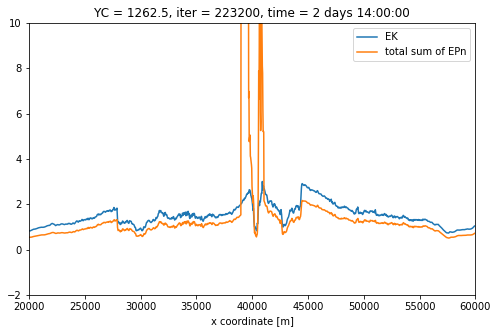

In [25]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(EP*ds1['drF']*ds1['hFacC']*ds1['maskC']).sum('Z').isel(time=t_st,YC=50).plot(ax=ax,label="EK")

ax.plot(xc,total_EP_n[50,:],label="total sum of EPn")
ax.legend()
ax.set_ylim(-2,10)
ax.set_xlim(20000,60000)

Text(0.5, 1.0, 'Fx1')

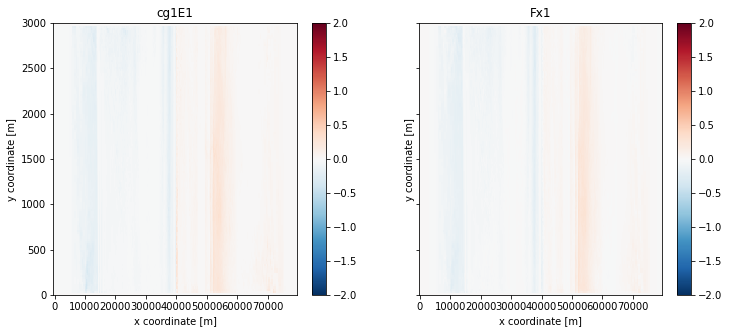

In [26]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cE0.plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("cg1E1")

fx0.plot(ax=ax[1],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("Fx1")

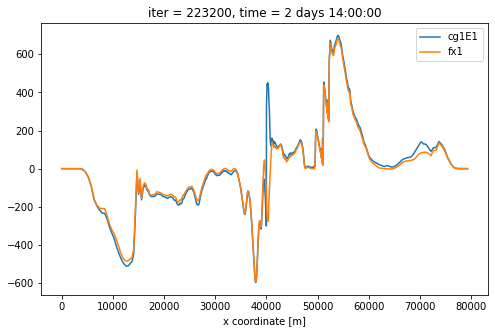

In [27]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cE0*ds1.dyG).sum(dim="YC").plot(ax=ax,label="cg1E1")
(fx0*ds1.dyG).sum(dim="YC").plot(ax=ax,label="fx1")

ax.legend()
#ax.set_ylim(-2,10)
#ax.set_xlim(20000,60000)

Text(0.5, 1.0, 'Fx2')

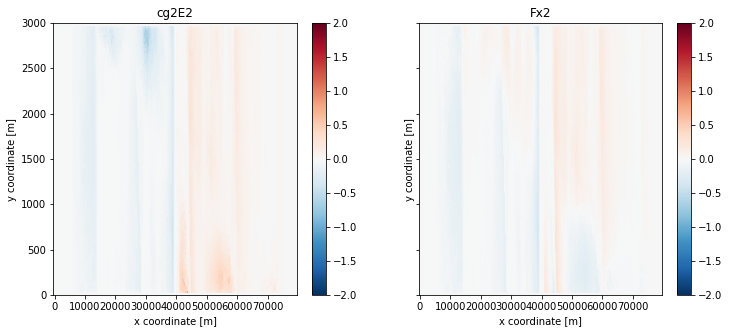

In [28]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cE1.plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("cg2E2")

fx1.plot(ax=ax[1],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("Fx2")

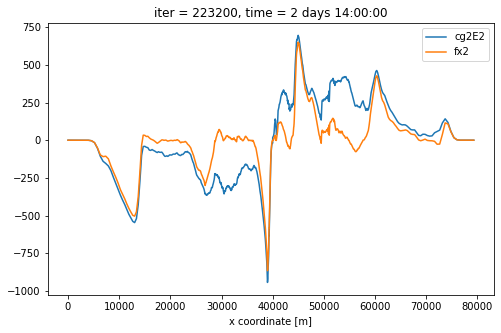

In [29]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cE1*ds1.dyG).sum(dim="YC").plot(ax=ax,label="cg2E2")
(fx1*ds1.dyG).sum(dim="YC").plot(ax=ax,label="fx2")

ax.legend()
#ax.set_ylim(-2,10)
#ax.set_xlim(20000,60000)

Text(0.5, 1.0, 'Fx3')

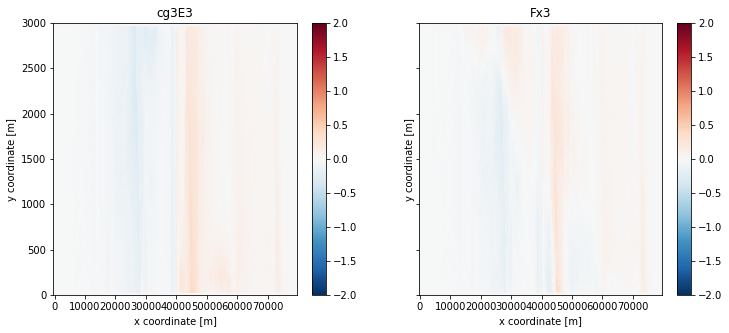

In [30]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cE2.plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("cg3E3")

fx2.plot(ax=ax[1],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("Fx3")

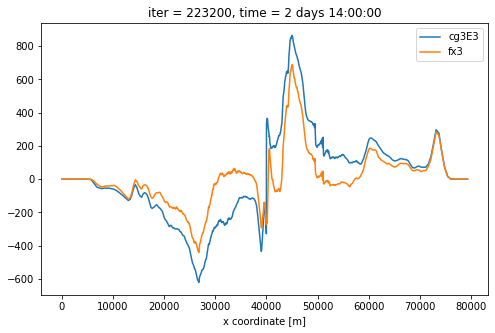

In [31]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cE2*ds1.dyG).sum(dim="YC").plot(ax=ax,label="cg3E3")
(fx2*ds1.dyG).sum(dim="YC").plot(ax=ax,label="fx3")

ax.legend()
#ax.set_ylim(-2,10)
#ax.set_xlim(20000,60000)

Text(0.5, 1.0, 'Fx4')

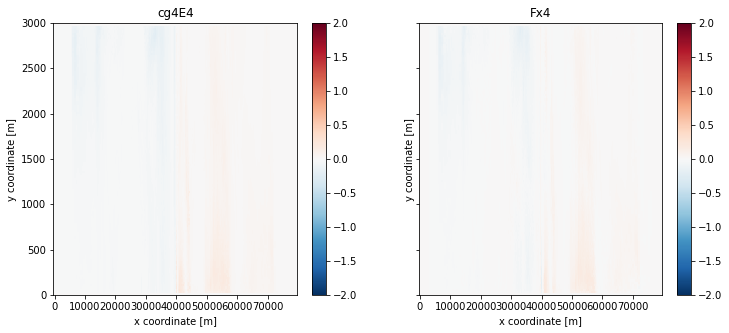

In [32]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cE3.plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("cg4E4")

fx3.plot(ax=ax[1],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("Fx4")

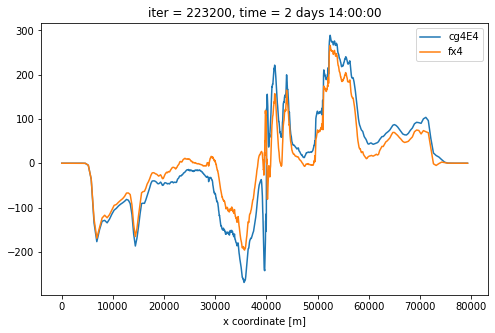

In [33]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cE3*ds1.dyG).sum(dim="YC").plot(ax=ax,label="cg4E4")
(fx3*ds1.dyG).sum(dim="YC").plot(ax=ax,label="fx4")

ax.legend()
#ax.set_ylim(-2,10)
#ax.set_xlim(20000,60000)

Text(0.5, 1.0, 'Fx5')

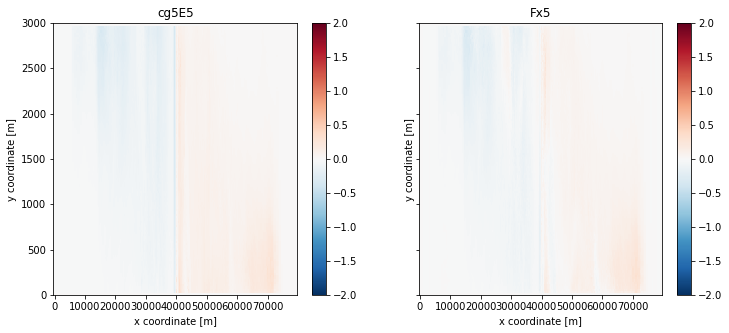

In [34]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cE4.plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("cg5E5")

fx4.plot(ax=ax[1],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("Fx5")

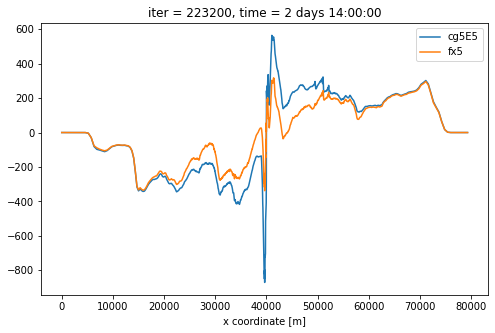

In [35]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cE4*ds1.dyG).sum(dim="YC").plot(ax=ax,label="cg5E5")
(fx4*ds1.dyG).sum(dim="YC").plot(ax=ax,label="fx5")

ax.legend()
#ax.set_ylim(-2,10)
#ax.set_xlim(20000,60000)

Text(0.5, 1.0, 'Fx6')

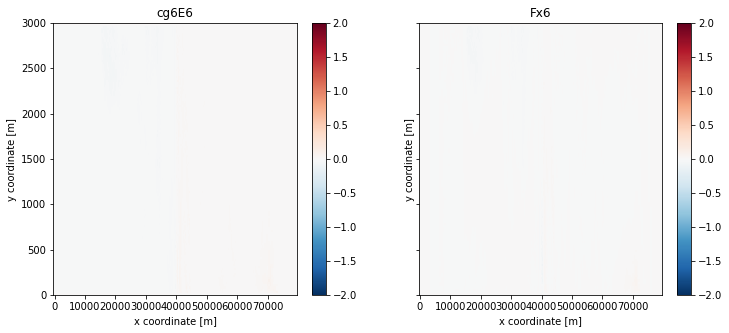

In [36]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cE5.plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("cg6E6")

fx5.plot(ax=ax[1],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("Fx6")

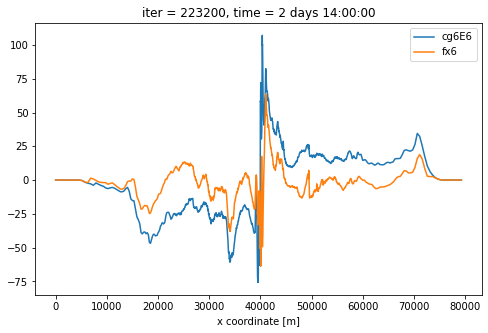

In [37]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cE5*ds1.dyG).sum(dim="YC").plot(ax=ax,label="cg6E6")
(fx5*ds1.dyG).sum(dim="YC").plot(ax=ax,label="fx6")

ax.legend()
#ax.set_ylim(-2,10)
#ax.set_xlim(20000,60000)

Text(0.5, 1.0, 'Fx7')

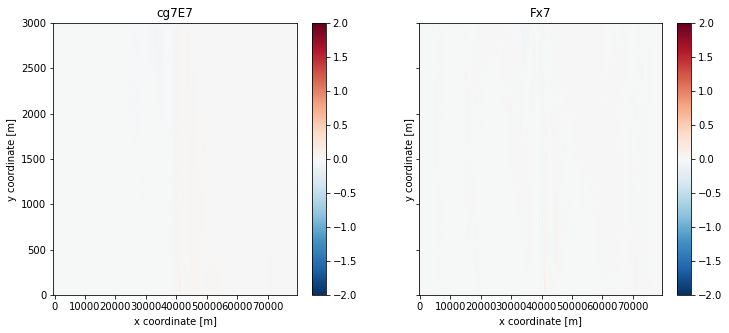

In [38]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cE6.plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("cg7E7")

fx6.plot(ax=ax[1],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("Fx7")

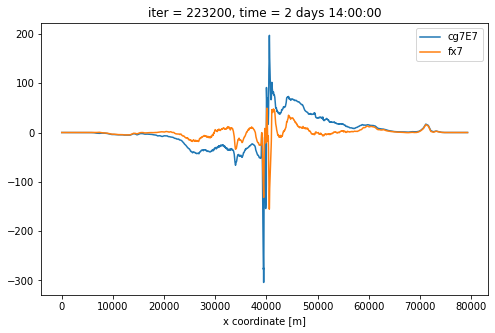

In [39]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cE6*ds1.dyG).sum(dim="YC").plot(ax=ax,label="cg7E7")
(fx6*ds1.dyG).sum(dim="YC").plot(ax=ax,label="fx7")

ax.legend()
#ax.set_ylim(-2,10)
#ax.set_xlim(20000,60000)

Text(0.5, 1.0, 'Fx8')

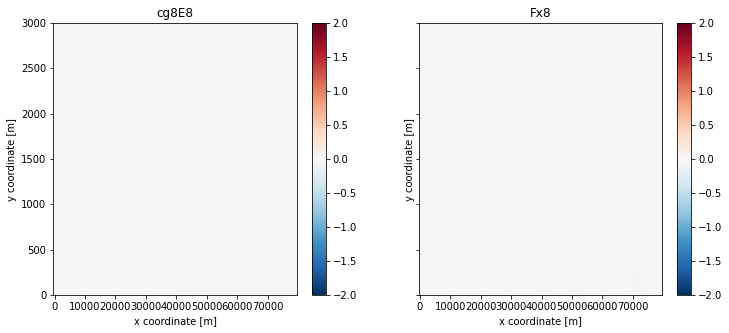

In [40]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cE7.plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("cg8E8")

fx7.plot(ax=ax[1],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("Fx8")

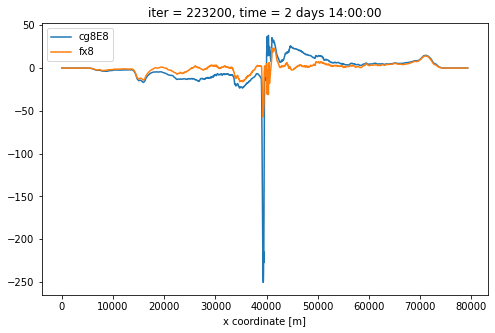

In [41]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cE7*ds1.dyG).sum(dim="YC").plot(ax=ax,label="cg8E8")
(fx7*ds1.dyG).sum(dim="YC").plot(ax=ax,label="fx8")

ax.legend()
#ax.set_ylim(-2,10)
#ax.set_xlim(20000,60000)

Text(0.5, 1.0, 'Fx9')

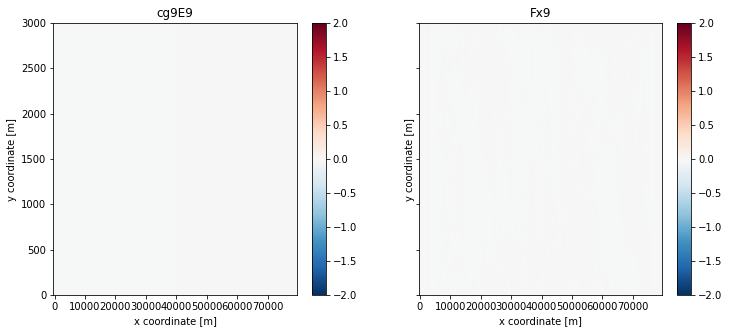

In [42]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cE8.plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("cg9E9")

fx8.plot(ax=ax[1],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("Fx9")

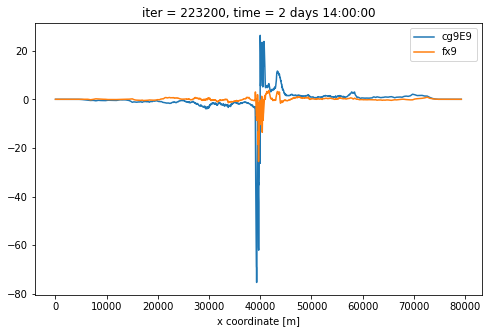

In [43]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cE8*ds1.dyG).sum(dim="YC").plot(ax=ax,label="cg9E9")
(fx8*ds1.dyG).sum(dim="YC").plot(ax=ax,label="fx9")

ax.legend()
#ax.set_ylim(-2,10)
#ax.set_xlim(20000,60000)

Text(0.5, 1.0, 'Fx10')

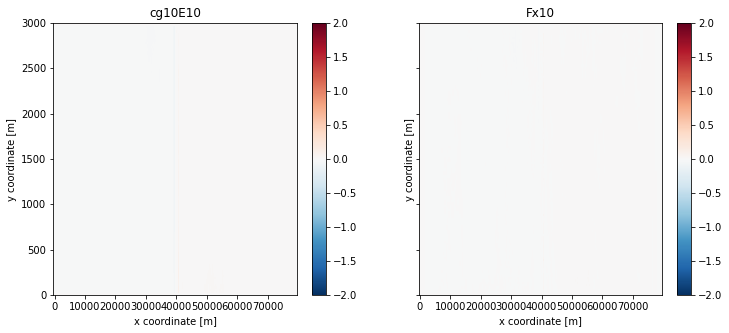

In [44]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cE9.plot(ax=ax[0],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("cg10E10")

fx9.plot(ax=ax[1],y="YC",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("Fx10")

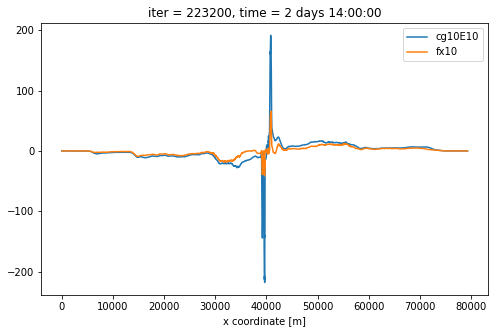

In [45]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cE9*ds1.dyG).sum(dim="YC").plot(ax=ax,label="cg10E10")
(fx9*ds1.dyG).sum(dim="YC").plot(ax=ax,label="fx10")

ax.legend()
#ax.set_ylim(-2,10)
#ax.set_xlim(20000,60000)